# Multi-modal Embedding using CLIP Large 14

## Imports and Utilities

In [1]:
from sentence_transformers import SentenceTransformer, util, models, InputExample, losses
from PIL import Image
import glob
import torch
from torch.utils.data import DataLoader
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import pandas as pd
import os
from tqdm.autonotebook import tqdm, trange
import torch
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [2]:
image_folder = 'images/'
def show_image(img_id, img_folder=image_folder):
    try:
        image_link = img_folder + img_id + '.jpg'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    except:
        image_link = img_folder + img_id + '.png'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    plt.imshow(image)
    plt.show()

In [3]:
import random
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [4]:
df = pd.read_csv('data/tweets_subset.csv', index_col='Unnamed: 0').reset_index()
df[df.available].head()

,index,id,skepticism,mainstream,label,text_NL,text_EN,split,available,target,unseen_images
956,956,327027443732983808,False,True,1,"RT @USER : 3D waterkaart , hoe stroomt het wat...","RT @USER : 3D water map , how the water flows ...",test,True,3_327026285966667776,1
1211,1211,375896131127218176,False,True,1,Kom naar de Wilhelminakade R'dam en klim boven...,Come to the Wilhelminakade R'dam and climb abo...,val,True,3_375896131013971968,1
1212,1212,375899134915772416,False,True,1,RT @USER : Kom naar de Wilhelminakade R'dam en...,RT @USER : Come to the Wilhelminakade R'dam an...,val,True,3_375896131013971968,1
1214,1214,375946829881278464,False,True,1,Scholieren klimmen met Jeugdwaterschap naar ni...,Students climb to the water level of their hou...,val,True,3_375946829747089408,0
1215,1215,375946961951539200,False,True,1,RT @USER : Scholieren klimmen met Jeugdwatersc...,RT @USER : Students climb to the water level o...,train,True,3_375946829747089408,0


In [5]:
# We use the original CLIP model for computing image embeddings and English text embeddings
en_model = SentenceTransformer('clip-ViT-L-14')
tokenizer = en_model._first_module().processor.tokenizer

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
def embed_documents(documents, embedding_model=en_model, convert_to_tensor = True, verbose = False):
    """ Embed a list of n documents/words into an n-dimensional
    matrix of embeddings

    Arguments:
        documents: A list of documents or words to be embedded
        verbose: Controls the verbosity of the process

    Returns:
        Document/words embeddings with shape (n, m) with `n` documents/words
        that each have an embeddings size of `m`
    """
    truncated_docs = [truncate_document(doc) for doc in documents]
    embeddings = embedding_model.encode(truncated_docs, show_progress_bar=verbose, convert_to_tensor=convert_to_tensor)
    return embeddings

def truncate_document(document, tokenizer=tokenizer):
    tokens = tokenizer.encode(document)

    if len(tokens) > 77:
        # Skip the starting token, only include 75 tokens
        truncated_tokens = tokens[1:76]
        document = tokenizer.decode(truncated_tokens)

        # Recursive call here, because the encode(decode()) can have different result
        return truncate_document(document)

    else:
        return document

In [7]:
df['text_EN_trun'] = df['text_EN'].apply(truncate_document)

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors


In [8]:
def embed_images(images, verbose=True, batch_size=32, embedding_model=en_model, convert_to_tensor=True):
    if batch_size:
        nr_iterations = int(np.ceil(len(images) / batch_size))

        # Embed images per batch
        embeddings = []
        for i in tqdm(range(nr_iterations), disable=not verbose):
            start_index = i * batch_size
            end_index = (i * batch_size) + batch_size

            images_to_embed = [Image.open(img_name_dict[image]) if (isinstance(image, str) and not str(image)=='nan') 
                               else (Image.new('RGB', (800, 600), color = (255,255,255)) if str(image)=='nan'
                               else image) for image in images[start_index:end_index]]
            img_emb = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
            embeddings.extend(img_emb.tolist())

            # Close images
            if isinstance(images[0], str):
                for image in images_to_embed:
                    image.close()
        if not convert_to_tensor:
            embeddings = np.array(embeddings)
        else:
            embeddings = torch.tensor(embeddings).to(device='cuda')
    else:
        images_to_embed = [Image.open(filepath) for filepath in images]
        embeddings = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
    return embeddings

In [9]:
def return_report(labels, preds, ids=[]):
    if len(ids)==0:
        print(metrics.classification_report(labels.cpu(), preds.cpu(), digits=4))
        return metrics.classification_report(labels.cpu(), preds.cpu(), digits=4, output_dict=True)
    else:
        print(metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4))
        return metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4, output_dict=True)

def evaluate_dataset_F1(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    test = df[df['split'] == 'test'].index
    image = df[df['available']].index
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        temp = val.copy()
    elif val_set=='test':
        temp = test.copy()
    
    a = temp.intersection(image)
    b = temp.difference(image)
    c = temp.intersection(image).intersection(unseen)    
    
    print('Overall Dataset:')
    all_report = return_report(label_all, preds_all)
    
    print('Training Set:')
    train_report = return_report(label_all, preds_all, train)
    
    print('Validation Set:')
    val_report = return_report(label_all, preds_all, temp)
    
    print('Validation Set with both Images and Texts:')
    val_img_report = return_report(label_all, preds_all, a)
    
    print('Validation Set with only Texts:')
    val_txt_report = return_report(label_all, preds_all, b)
    
    print('Validation Set with unseen Images:')
    val_unseen_report = return_report(label_all, preds_all, c)
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    val_acc = ((label_all[torch.tensor(list(temp))]==preds_all[torch.tensor(list(temp))]).sum()/len(temp)).item()*100
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_report, train_report, val_report, val_img_report, val_txt_report, val_unseen_report

In [10]:
def evaluate_dataset(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    #train = torch.tensor(np.array(df_all['split'] == 'train')).to(device).float()
    train = df[df['split'] == 'train'].index
    #val = torch.tensor(np.array(df_all['split'] == 'val')).to(device).float()
    val = df[df['split'] == 'val'].index
    #test = torch.tensor(np.array(df_all['split'] == 'test')).to(device).float()
    test = df[df['split'] == 'test'].index
    #image = torch.tensor(np.array(df_all['available'])).to(device).float()
    image = df[df['available']].index
    #unseen = torch.tensor(np.array(df_all['unseen_images'])).to(device).float()
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        a = val.intersection(image)
        b = val.difference(image)
        c = val.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(val))]==preds_all[torch.tensor(list(val))]).sum()/len(val)).item()*100
            
    elif val_set=='test':
        a = test.intersection(image)
        b = test.difference(image)
        c = test.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(test))]==preds_all[torch.tensor(list(test))]).sum()/len(test)).item()*100
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen

## Process Raw Data into Embeddings

Two sentences to compute embeddings

In [11]:
labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
          'Climate change is not even a real problem to concern about! I do not believe in it!']
lab_emb = en_model.encode(labels, convert_to_tensor=True)
empty_img_emb = embed_images(['nan'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
empty_img_emb.shape

torch.Size([1, 768])

In [ ]:
txt_emb = embed_documents(list(df['text_EN']), convert_to_tensor=True, verbose=True)

In [ ]:
img_emb = embed_images(list(df['target']), convert_to_tensor=True)

In [ ]:
import pickle
with open('data/CLIP14/embeddings.pkl', "wb") as fOut:
    pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 
                 'lab_emb': lab_emb, 'empty_img_emb': empty_img_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('data/CLIP14/embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    #stored_sentences = stored_data['sentences']
    txt_emb = stored_data['txt_emb']
    img_emb = stored_data['img_emb']
    lab_emb = stored_data['lab_emb']
    empty_img_emb = stored_data['empty_img_emb']

labs = {}
labs['txt_emb'] = lab_emb
labs['img_emb'] = torch.vstack([empty_img_emb] * lab_emb.shape[0])
mul_emb = (img_emb + txt_emb)/2

## Zero-shot Classification

Using Cosine Similarity to make classification

In [15]:
def zero_shot(df_all, model_name='CLIP14', merge = 'average', from_stored_embedding=False, pre_computed = True,
             stored_data='', embedding_model = '', val_set='val'):
    
    if from_stored_embedding:
        folder = 'model_storage/{}/embeddings.pkl'.format(model_name)
        with open(folder, "rb") as fIn:
            stored_data = pickle.load(fIn)
            #stored_sentences = stored_data['sentences']
            txt_emb = stored_data['txt_emb']
            img_emb = stored_data['img_emb']
            lab_emb = stored_data['lab_emb']
    elif pre_computed:
        stored_data = stored_data
        #stored_sentences = stored_data['sentences']
        txt_emb = stored_data['txt_emb']
        img_emb = stored_data['img_emb']
        lab_emb = stored_data['lab_emb']
    else:
        txt_emb = embed_documents(list(df_all['text_EN_trun']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        img_emb = embed_images(list(df_all['target']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
                  'Climate change is not even a real problem to concern about! I do not believe in it!']
        lab_emb = embedding_model.encode(labels, convert_to_tensor=True)
        with open('model_storage/CLIP/embeddings_re.pkl', "wb") as fOut:
            pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 'lab_emb': lab_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    
    if merge == 'average':
        mul_emb = (img_emb + txt_emb)/2
    elif merge == 'max':
        mul_emb = torch.max(img_emb, txt_emb)
    else:
        print("'Merger' input must be one of 'average' or 'max'")
    
    TXT_LAB = util.cos_sim(lab_emb, txt_emb)
    IMG_LAB = util.cos_sim(lab_emb, img_emb)
    MUL_LAB = util.cos_sim(lab_emb, mul_emb)
    
    pred_TXT = torch.argmax(TXT_LAB[:2,:], dim=0).float()
    pred_IMG = torch.argmax(IMG_LAB[:2,:], dim=0).float()
    pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
    
    lab = torch.tensor(np.array(df_all['skepticism'])).to('cuda').float()
    
    set_seed_everywhere(42, cuda=True)
    lab_rand = (torch.rand(len(lab))>0.5).float().to('cuda')
    
    print('Using textual embedding only:')
    evaluate_dataset(df_all, pred_TXT, val_set=val_set)
    
    print('Using image embedding only:')
    evaluate_dataset(df_all, pred_IMG, val_set=val_set)
    
    print('Using multi-modal embedding:')
    evaluate_dataset(df_all, pred_MUL, val_set=val_set)
    
    print('Comparing to a random prediction:')
    evaluate_dataset(df_all, lab_rand, val_set=val_set)
    
    print('Test set performance multi-modal:')
    evaluate_dataset(df_all, pred_MUL, val_set='test')
    
    return

In [16]:
zero_shot(df, stored_data = stored_data)

Using textual embedding only:

    Overall Accuracy: 63.39
    Training Set Accuracy: 63.48
    Validation Set Accuracy: 63.96
    Validation Set with both Images and Texts: 74.78
    Validation Set with only Texts: 61.97
    Validation Set with unseen Images: 68.74
    
Using image embedding only:

    Overall Accuracy: 42.60
    Training Set Accuracy: 42.71
    Validation Set Accuracy: 42.87
    Validation Set with both Images and Texts: 45.04
    Validation Set with only Texts: 42.47
    Validation Set with unseen Images: 46.38
    
Using multi-modal embedding:

    Overall Accuracy: 58.10
    Training Set Accuracy: 58.01
    Validation Set Accuracy: 58.60
    Validation Set with both Images and Texts: 63.83
    Validation Set with only Texts: 57.64
    Validation Set with unseen Images: 59.21
    
Comparing to a random prediction:

    Overall Accuracy: 49.64
    Training Set Accuracy: 49.67
    Validation Set Accuracy: 49.99
    Validation Set with both Images and Texts: 48.09
   

## Training an additional MLP

In [65]:
from argparse import Namespace
args = Namespace(
    # Data and Path information
    model_state_file='MLP_classifier.pth',
    save_dir='model_storage/CLIP14/',
    result_dir='results/CLIP14/',
    embedding_size=768,
    early_stopping_criteria=20,
    num_epochs=20,
    seed=42,
    
    # Training hyper parameters
    batch_size=32,
    embedding_type='text',
    fusion_type='average',
    hidden_dim=128, 
    learning_rate=5e-5,
    l2=1e-5,
    dropout_p=0.1,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    device= 'cuda',
    cuda=True,
    verbose=True,
)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MLPClassifier(nn.Module):
    
    def __init__(self, embedding_size, embedding_type, fusion_type, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
            fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                                {'average', 'concat', 'complex'}
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained embeddings
            
        """
        super(MLPClassifier, self).__init__()

        self.embedding_type = embedding_type
        self.fusion_type = fusion_type
        self._dropout_p = dropout_p
        self.dropout = nn.Dropout(dropout_p)
        #self.prelu = nn.PReLU()
        
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        self.fc_concat = nn.Linear(2*embedding_size, hidden_dim)
        self.fc_complex = nn.Linear(5*embedding_size, 2*embedding_size)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (dictionary): a dictionary of input data tensors with embeddings. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = x_in
                
        # logistic regression
        if (not self.embedding_type=='multi') or self.fusion_type=='average':
            intermediate_vector = F.relu(self.dropout(self.fc1(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='concat':
            intermediate_vector = F.relu(self.dropout(self.fc_concat(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='complex':
            first_vector = F.relu(self.dropout(self.fc_complex(x_embedded)))
            intermediate_vector = F.relu(self.dropout(self.fc_concat(first_vector)))
            prediction_vector = self.fc2(intermediate_vector)
        
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [19]:
class CustomDataset(Dataset):
    def __init__(self, df_all, embeddings):
        self.df = df_all
        self.labels = torch.tensor(np.array(self.df['skepticism'])).to(args.device).float()
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, self.df.text_EN_trun)) + 0
        self.embeddings = embeddings
        
        train = torch.tensor(df[df['split'] == 'train'].index)
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.train_emb = self.embeddings[train]
        
        val = torch.tensor(df[df['split'] == 'val'].index)
        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)
        self.val_emb = self.embeddings[val]
                
        test = torch.tensor(df[df['split'] == 'test'].index)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.test_emb = self.embeddings[test]

        self._lookup_dict = {'train': (self.train_df, self.train_size, self.train_emb),
                             'val': (self.val_df, self.validation_size, self.val_emb),
                             'test': (self.test_df, self.test_size, self.test_emb)}

        self.set_split('train')
            
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size, self._target_emb = self._lookup_dict[split]
        
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        if len(self) % batch_size==0:
            return len(self) // batch_size
        else:
            return len(self) // batch_size + 1

    def __len__(self):
        return self._target_size

    def __getitem__(self, idx):
        emb = self._target_emb[idx].to(args.device)
        row = self._target_df.iloc[idx]
        label = torch.tensor(row[['mainstream', 'skepticism']].astype(int)).to(args.device)
        
        return {'emb': emb, 
                'label': label}

In [20]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_1_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'golden_loss': [],
            'train_loss': [],
            'train_1_acc': [],
            'train_acc': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_acc': [],
            'val_img_txt': [],
            'val_txt_only': [],
            'val_unseen_img': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_acc': -1,
            'test_img_txt': -1,
            'test_txt_only': -1,
            'test_unseen_img': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_1_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_1_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_1_acc_val']:
                train_state['early_stopping_best_1_acc_val'] = acc_t
                torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [21]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [22]:
def softmax_sensitive(T):
    T = np.exp(T) - np.exp(0) + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [23]:
def prepare_embedding(embeddings, embedding_type, fusion_type):
    '''
    Args:
        embeddings (dictionary): a dictionary of input data tensors with embeddings. 
        embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
        fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                        {'average', 'concat', 'complex'}'''
    if embedding_type=='text':
        x_embedded = embeddings['txt_emb']
    elif embedding_type=='image':
        x_embedded = embeddings['img_emb']
    elif embedding_type=='multi':
        if fusion_type=='average':
            x_embedded = (embeddings['txt_emb']+embeddings['img_emb'])/2
        elif fusion_type=='concat':
            x_embedded = torch.hstack([embeddings['txt_emb'], embeddings['img_emb']])
        elif fusion_type=='complex':
            txt_emb = embeddings['txt_emb']
            img_emb = embeddings['img_emb']
            x_embedded = torch.hstack([txt_emb, img_emb, txt_emb+img_emb, txt_emb-img_emb, txt_emb*img_emb])
        else:
            print('fusion_type is not supported')
    else:
        print('embedding_type is not supported')
        
    return x_embedded

In [24]:
def initialization(df, stored_data):
    set_seed_everywhere(args.seed, args.cuda)
    embeddings = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
    dataset = CustomDataset(df, embeddings)
    
    classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
    
    return embeddings, dataset, classifier

In [25]:
def write_train_state_evaluation(classifier, embeddings, train_state, df):
    preds_all = classifier(embeddings).argmax(dim=1)
    _, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen = evaluate_dataset(df, preds_all)
    
    train_state['train_acc'].append(train_acc)
    train_state['val_acc'].append(val_acc)
    train_state['val_img_txt'].append(val_img_acc)
    train_state['val_txt_only'].append(val_txt_acc)
    train_state['val_unseen_img'].append(val_unseen)
    
    return train_state

In [26]:
def training_loop(df, stored_data, labs=None, verbose=True):
    
    embeddings, dataset, classifier = initialization(df, stored_data)
    if labs:
        lab_embeddings = prepare_embedding(labs, args.embedding_type, args.fusion_type)
    classifier = classifier.to(args.device)

    loss_func = cross_entropy
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)
    train_state = make_train_state(args)
    
    print('Using {} embedding with {} fusion method'.format(args.embedding_type, args.fusion_type))
    
    set_seed_everywhere(args.seed, cuda=True)
    train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
    
    set_seed_everywhere(args.seed, cuda=True)
    try:
        for epoch_index in trange(args.num_epochs, desc="Epoch", disable=not args.verbose):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            train_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
            
            running_loss = 0.0
            running_1_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(train_dataloader):

                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']

                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()

                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)
                
                # step 5. use loss to produce gradients
                loss.backward()

                # step 6. use optimizer to take gradient step
                optimizer.step()

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)
            
            if labs:
                optimizer.zero_grad()
                y_pred = classifier(lab_embeddings)
                y = torch.tensor([[1,0], [0,1]]).to(args.device)
                loss = loss_func(y_pred, y)
                loss.backward()
                optimizer.step()
                train_state['golden_loss'].append(loss.item())
            else:
                train_state['golden_loss'].append('not implemented')
            
            train_state['train_loss'].append(running_loss)
            train_state['train_1_acc'].append(running_1_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on

            dataset.set_split('val')
            val_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

            running_loss = 0.0
            running_1_acc = 0.0
            classifier.eval()

            for batch_index, batch_dict in enumerate(val_dataloader):

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']
                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()
                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)

            train_state['val_loss'].append(running_loss)
            train_state['val_1_acc'].append(running_1_acc)

            train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
            
            print('Current Running Accuracy Training Set: {:.2f}, Validation Set: {:.2f}, Golden Set: {:.2f}'.format(train_state['train_1_acc'][-1], train_state['val_1_acc'][-1], train_state['golden_loss'][-1]))

            train_state = update_train_state(args=args, model=classifier, train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            with open(args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + 'train_state.p', 'wb') as fp:
                pickle.dump(train_state, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [27]:
def experiment(df, stored_data, labs = None, hyperdict={}):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for key in combi:
        print(key)
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        if not key in hyperdict:
            train_state = training_loop(df, stored_data, labs=labs)
            hyperdict[key] = train_state
            
        with open(args.save_dir+'hyperdict.p', 'wb') as fp:
            pickle.dump(hyperdict,fp, protocol=pickle.HIGHEST_PROTOCOL)    

In [28]:
def demonstration(hyperdict):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    metrics = ['train_acc', 'val_acc', 'val_img_txt', 'val_txt_only', 'val_unseen_img']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for m in metrics:
        print(m)
        for key in combi:
            train_state = hyperdict[key]
            pd.Series(train_state[m]).plot(label=str(key))
            plt.legend()
        plt.show()

In [29]:
def statistics(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [30]:
def statistics_F1(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        #pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset_F1(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset_F1(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [ ]:
hyperdict = {}
experiment(df, stored_data, hyperdict)

In [ ]:
hyperdict = {}
experiment(df, stored_data, labs, hyperdict)

## Performance on Trained Models

In [31]:
perform_results = {}
for o in ['O1', 'O2']:
    perform_results[o] = {}

In [32]:
with open(args.save_dir+'001/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


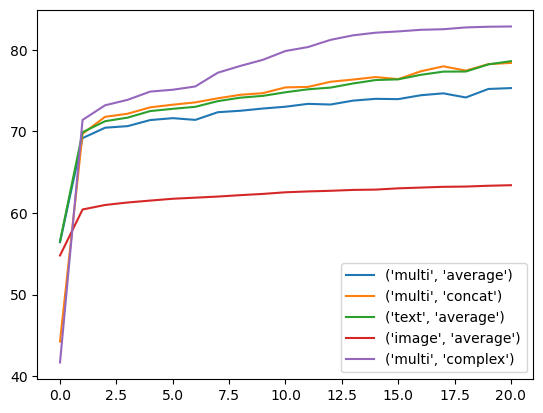

val_acc


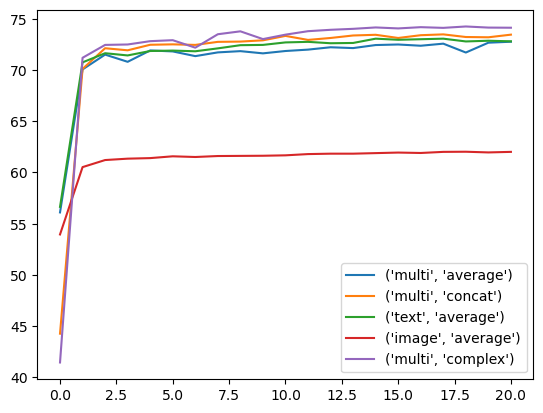

val_img_txt


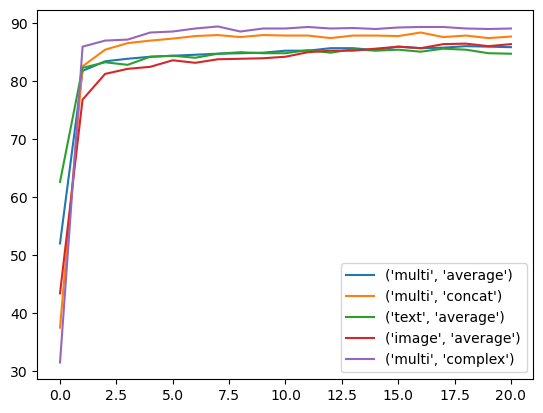

val_txt_only


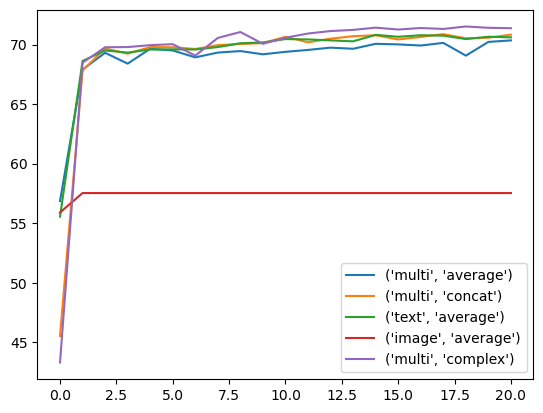

val_unseen_img


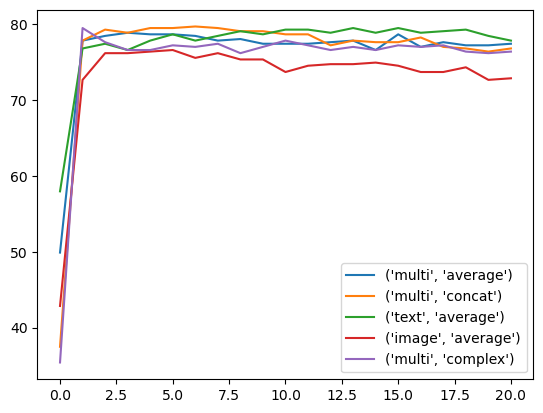

In [33]:
demonstration(hyperdict)

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7844    0.7869    0.7857     29306
         1.0     0.6865    0.6832    0.6848     20010

    accuracy                         0.7448     49316
   macro avg     0.7354    0.7351    0.7352     49316
weighted avg     0.7447    0.7448    0.7448     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7909    0.7933    0.7921     20463
         1.0     0.6977    0.6946    0.6962     14058

    accuracy                         0.7531     34521
   macro avg     0.7443    0.7440    0.7441     34521
weighted avg     0.7529    0.7531    0.7530     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7692    0.7743    0.7718      4400
         1.0     0.6654    0.6590    0.6622      2997

    accuracy                         0.7276      7397
   macro avg     0.7173    0.7167    0.7170

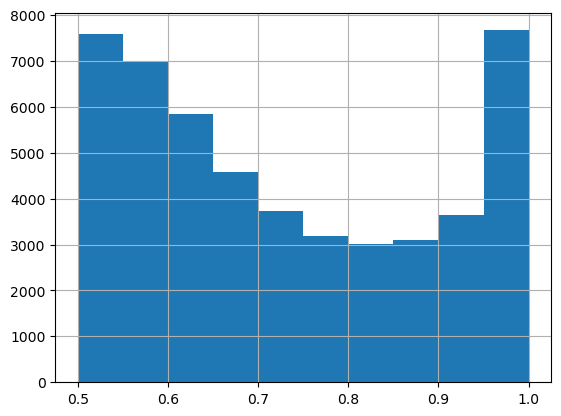

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8107    0.7893    0.7999     29306
         1.0     0.7029    0.7301    0.7163     20010

    accuracy                         0.7653     49316
   macro avg     0.7568    0.7597    0.7581     49316
weighted avg     0.7670    0.7653    0.7659     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8229    0.8009    0.8117     20463
         1.0     0.7210    0.7490    0.7348     14058

    accuracy                         0.7798     34521
   macro avg     0.7720    0.7750    0.7733     34521
weighted avg     0.7814    0.7798    0.7804     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7831    0.7664    0.7746      4400
         1.0     0.6674    0.6884    0.6777      2997

    accuracy                         0.7348      7397
   macro avg     0.7253    0.7274    0.7262 

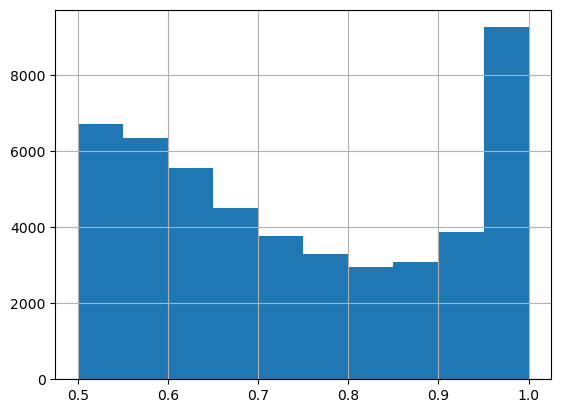

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8101    0.7623    0.7855     29306
         1.0     0.6796    0.7383    0.7077     20010

    accuracy                         0.7526     49316
   macro avg     0.7448    0.7503    0.7466     49316
weighted avg     0.7571    0.7526    0.7539     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8186    0.7710    0.7941     20463
         1.0     0.6927    0.7512    0.7208     14058

    accuracy                         0.7630     34521
   macro avg     0.7556    0.7611    0.7574     34521
weighted avg     0.7673    0.7630    0.7642     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7902    0.7448    0.7668      4400
         1.0     0.6545    0.7097    0.6810      2997

    accuracy                         0.7306      7397
   macro avg     0.7223    0.7272    0.7239 

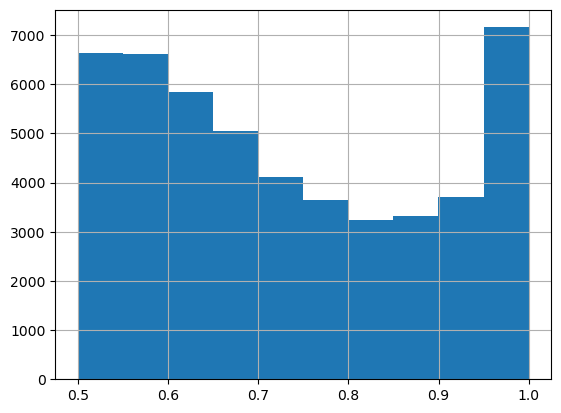

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6170    0.9937    0.7613     29306
         1.0     0.9127    0.0966    0.1747     20010

    accuracy                         0.6297     49316
   macro avg     0.7648    0.5451    0.4680     49316
weighted avg     0.7370    0.6297    0.5233     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6178    0.9962    0.7627     20463
         1.0     0.9489    0.1030    0.1858     14058

    accuracy                         0.6325     34521
   macro avg     0.7834    0.5496    0.4742     34521
weighted avg     0.7526    0.6325    0.5278     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6121    0.9870    0.7556      4400
         1.0     0.8113    0.0817    0.1485      2997

    accuracy                         0.6203      7397
   macro avg     0.7117    0.5344    0.4521

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6170    0.9937    0.7613     29306
         1.0     0.9127    0.0966    0.1747     20010

    accuracy                         0.6297     49316
   macro avg     0.7648    0.5451    0.4680     49316
weighted avg     0.7370    0.6297    0.5233     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6178    0.9962    0.7627     20463
         1.0     0.9489    0.1030    0.1858     14058

    accuracy                         0.6325     34521
   macro avg     0.7834    0.5496    0.4742     34521
weighted avg     0.7526    0.6325    0.5278     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6180    0.9887    0.7606      4443
         1.0     0.8276    0.0812    0.1479      2955

    accuracy                         0.6263      7398
   macro avg     0.7228    0.5350    0.4543      7398
weighted avg     0.7017    

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

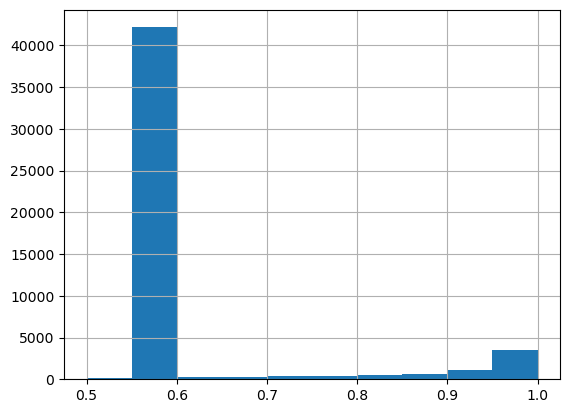

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8451    0.8132    0.8289     29306
         1.0     0.7408    0.7817    0.7607     20010

    accuracy                         0.8004     49316
   macro avg     0.7929    0.7975    0.7948     49316
weighted avg     0.8028    0.8004    0.8012     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8683    0.8356    0.8516     20463
         1.0     0.7731    0.8155    0.7938     14058

    accuracy                         0.8274     34521
   macro avg     0.8207    0.8256    0.8227     34521
weighted avg     0.8296    0.8274    0.8281     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7948    0.7643    0.7793      4400
         1.0     0.6725    0.7104    0.6909      2997

    accuracy                         0.7425      7397
   macro avg     0.7337    0.7373    0.7351

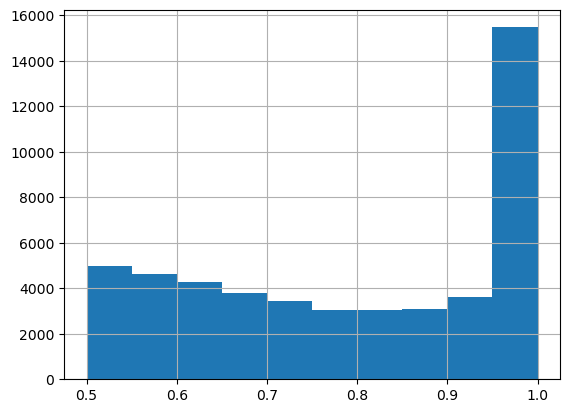

In [34]:
perform_results['O1'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='001/')

In [35]:
with open(args.save_dir+'002/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


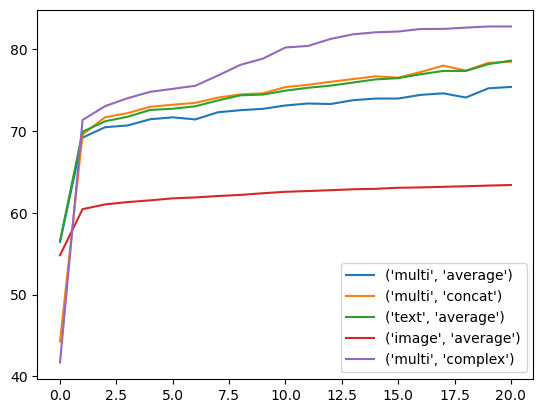

val_acc


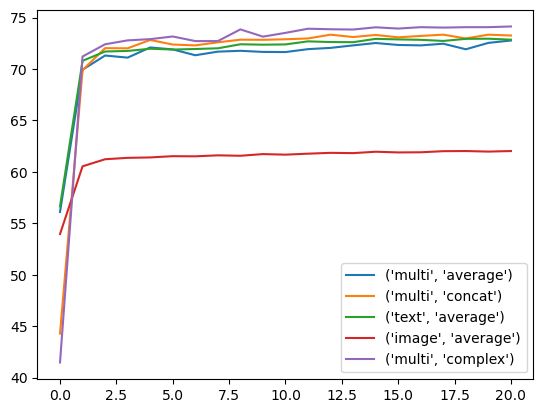

val_img_txt


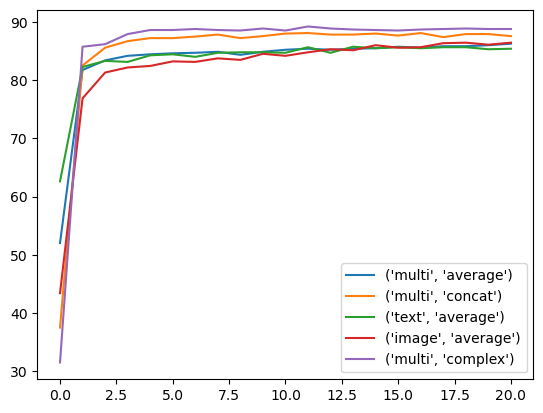

val_txt_only


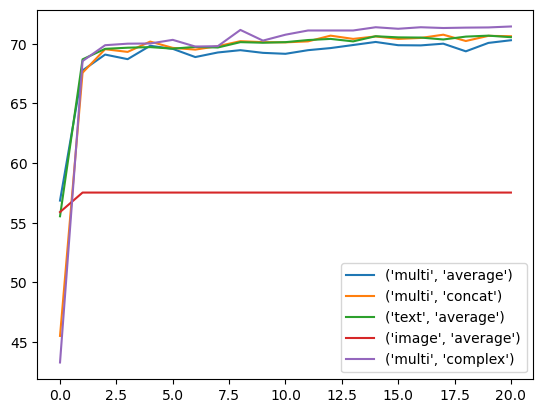

val_unseen_img


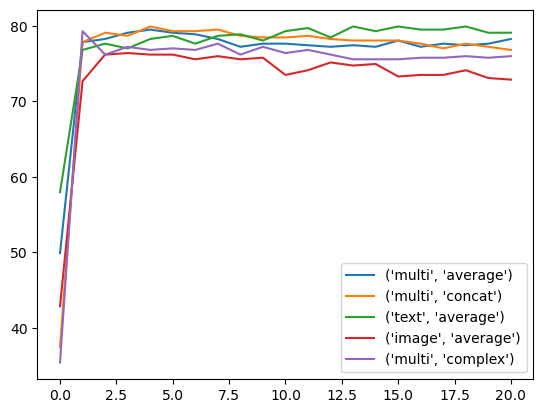

In [36]:
demonstration(hyperdict)

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7883    0.7807    0.7845     29306
         1.0     0.6833    0.6929    0.6880     20010

    accuracy                         0.7451     49316
   macro avg     0.7358    0.7368    0.7362     49316
weighted avg     0.7457    0.7451    0.7453     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7947    0.7884    0.7915     20463
         1.0     0.6955    0.7034    0.6994     14058

    accuracy                         0.7538     34521
   macro avg     0.7451    0.7459    0.7455     34521
weighted avg     0.7543    0.7538    0.7540     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7735    0.7668    0.7701      4400
         1.0     0.6619    0.6703    0.6661      2997

    accuracy                         0.7277      7397
   macro avg     0.7177    0.7186    0.7181

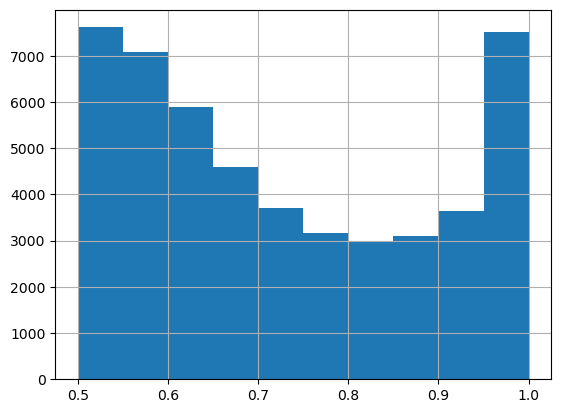

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8055    0.7966    0.8010     29306
         1.0     0.7068    0.7182    0.7125     20010

    accuracy                         0.7648     49316
   macro avg     0.7562    0.7574    0.7567     49316
weighted avg     0.7654    0.7648    0.7651     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8179    0.8086    0.8132     20463
         1.0     0.7259    0.7379    0.7319     14058

    accuracy                         0.7798     34521
   macro avg     0.7719    0.7733    0.7725     34521
weighted avg     0.7804    0.7798    0.7801     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7773    0.7734    0.7753      4400
         1.0     0.6698    0.6747    0.6722      2997

    accuracy                         0.7334      7397
   macro avg     0.7235    0.7240    0.7238 

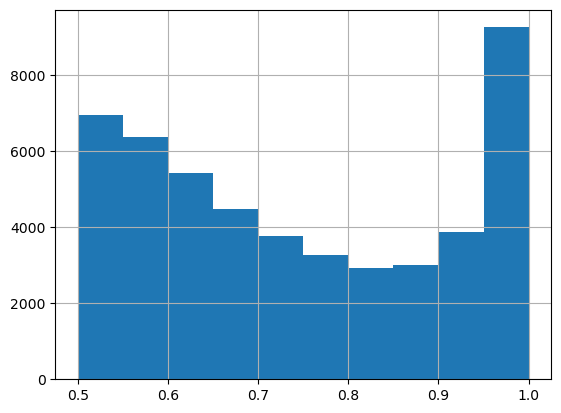

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8058    0.7982    0.8020     29306
         1.0     0.7085    0.7182    0.7133     20010

    accuracy                         0.7658     49316
   macro avg     0.7571    0.7582    0.7576     49316
weighted avg     0.7663    0.7658    0.7660     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8185    0.8117    0.8151     20463
         1.0     0.7292    0.7379    0.7335     14058

    accuracy                         0.7817     34521
   macro avg     0.7738    0.7748    0.7743     34521
weighted avg     0.7821    0.7817    0.7819     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7756    0.7673    0.7714      4400
         1.0     0.6636    0.6740    0.6688      2997

    accuracy                         0.7295      7397
   macro avg     0.7196    0.7206    0.7201 

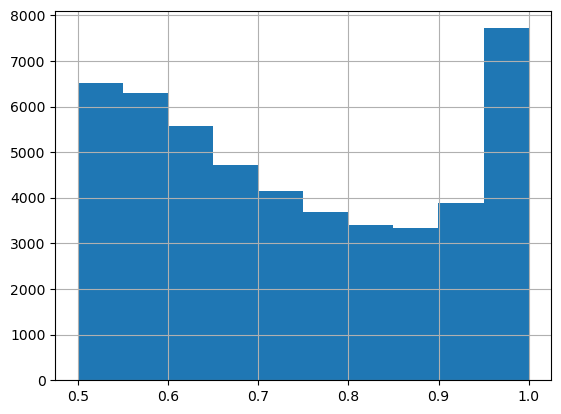

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6170    0.9932    0.7612     29306
         1.0     0.9075    0.0971    0.1753     20010

    accuracy                         0.6296     49316
   macro avg     0.7622    0.5451    0.4683     49316
weighted avg     0.7349    0.6296    0.5235     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6178    0.9959    0.7626     20463
         1.0     0.9453    0.1032    0.1861     14058

    accuracy                         0.6324     34521
   macro avg     0.7815    0.5496    0.4743     34521
weighted avg     0.7512    0.6324    0.5278     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6123    0.9859    0.7554      4400
         1.0     0.8013    0.0834    0.1511      2997

    accuracy                         0.6203      7397
   macro avg     0.7068    0.5347    0.4533

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

         0.0     0.7884    0.8395    0.8132       324
         1.0     0.6232    0.5409    0.5791       159

    accuracy                         0.7412       483
   macro avg     0.7058    0.6902    0.6961       483
weighted avg     0.7340    0.7412    0.7361       483


    Overall Accuracy: 62.96
    Training Set Accuracy: 63.24
    Validation Set Accuracy: 62.03
    Validation Set with both Images and Texts: 86.43
    Validation Set with only Texts: 57.53
    Validation Set with unseen Images: 74.12
    
Test Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6170    0.9932    0.7612     29306
         1.0     0.9075    0.0971    0.1753     20010

    accuracy                         0.6296     49316
   macro avg     0.7622    0.5451    0.4683     49316
weighted avg     0.7349    0.6296    0.5235     49316

Training Set:
              precision    recall  f1-score   support

        

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

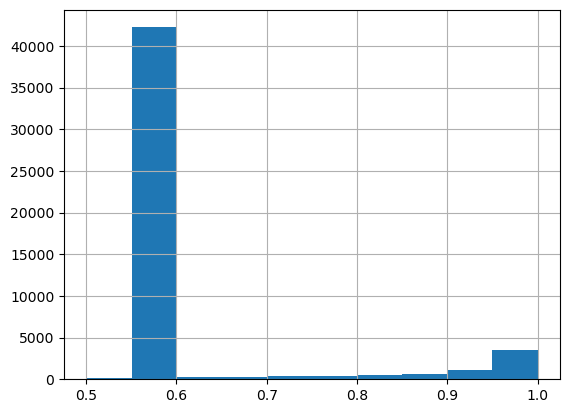

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8409    0.8196    0.8301     29306
         1.0     0.7453    0.7730    0.7589     20010

    accuracy                         0.8007     49316
   macro avg     0.7931    0.7963    0.7945     49316
weighted avg     0.8021    0.8007    0.8012     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8644    0.8414    0.8527     20463
         1.0     0.7777    0.8078    0.7925     14058

    accuracy                         0.8277     34521
   macro avg     0.8210    0.8246    0.8226     34521
weighted avg     0.8291    0.8277    0.8282     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7893    0.7711    0.7801      4400
         1.0     0.6750    0.6977    0.6861      2997

    accuracy                         0.7414      7397
   macro avg     0.7321    0.7344    0.7331

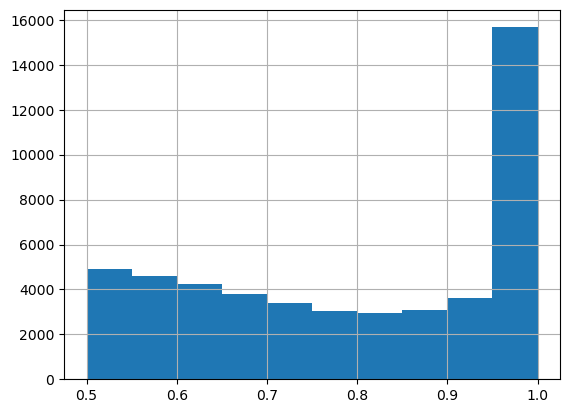

In [37]:
perform_results['O2'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='002/')

## Zero-shot Classification with Embeddings

In [38]:
embeddings = {}
for v in ['O1', 'O2']:
    embeddings[v] = {}
    for l in ['L2', 'L1', 'L0']:
        embeddings[v][l] = {}
        for t in ['val', 'test']:
            embeddings[v][l][t] = {}

In [39]:
embeddings

{'O1': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}},
 'O2': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}}}

### Option 1

In [40]:
args

Namespace(model_state_file='MLP_classifier.pth', save_dir='model_storage/CLIP14/', embedding_size=768, early_stopping_criteria=20, num_epochs=20, seed=42, batch_size=32, embedding_type='multi', fusion_type='complex', hidden_dim=128, learning_rate=5e-05, l2=1e-05, dropout_p=0.1, catch_keyboard_interrupt=True, device='cuda', cuda=True, verbose=True)

In [41]:
args.embedding_type = 'multi'
args.fusion_type = 'complex'

In [42]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '001/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1536, out_features=128, bias=True)
  (fc_complex): Linear(in_features=3840, out_features=1536, bias=True)
)

In [43]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [44]:
labs = {}
labs['txt_emb'] = stored_data['lab_emb']
empty_img_emb = stored_data['empty_img_emb']
labs['img_emb'] = torch.vstack([empty_img_emb] * labs['txt_emb'].shape[0])

In [45]:
labs['img_emb'].shape

torch.Size([2, 768])

In [46]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [47]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8487    0.7680    0.8063     29306
         1.0     0.7017    0.7995    0.7474     20010

    accuracy                         0.7808     49316
   macro avg     0.7752    0.7837    0.7769     49316
weighted avg     0.7891    0.7808    0.7824     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8667    0.7840    0.8233     20463
         1.0     0.7239    0.8245    0.7709     14058

    accuracy                         0.8005     34521
   macro avg     0.7953    0.8042    0.7971     34521
weighted avg     0.8086    0.8005    0.8020     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8103    0.7366    0.7717      4400
         1.0     0.6588    0.7467    0.7000      2997

    accuracy                         0.7407      7397
   macro avg     0.7345    0.7417    0

In [48]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1536])

In [49]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1536])

In [50]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6863    0.8372    0.7543     29306
         1.0     0.6483    0.4394    0.5238     20010

    accuracy                         0.6758     49316
   macro avg     0.6673    0.6383    0.6390     49316
weighted avg     0.6709    0.6758    0.6608     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6863    0.8359    0.7537     20463
         1.0     0.6501    0.4439    0.5276     14058

    accuracy                         0.6763     34521
   macro avg     0.6682    0.6399    0.6407     34521
weighted avg     0.6716    0.6763    0.6617     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6867    0.8407    0.7559      4400
         1.0     0.6512    0.4368    0.5229      2997

    accuracy                         0.6770      7397
   macro avg     0.6689    0.6387    0

In [51]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 3840])

In [52]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 3840])

In [53]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6277    0.8808    0.7330     29306
         1.0     0.5737    0.2348    0.3333     20010

    accuracy                         0.6187     49316
   macro avg     0.6007    0.5578    0.5331     49316
weighted avg     0.6058    0.6187    0.5708     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6254    0.8807    0.7314     20463
         1.0     0.5719    0.2320    0.3301     14058

    accuracy                         0.6165     34521
   macro avg     0.5986    0.5563    0.5307     34521
weighted avg     0.6036    0.6165    0.5680     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6324    0.8789    0.7355      4400
         1.0     0.5842    0.2499    0.3501      2997

    accuracy                         0.6240      7397
   macro avg     0.6083    0.5644    0

### Option 2

In [54]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '002/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file,map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1536, out_features=128, bias=True)
  (fc_complex): Linear(in_features=3840, out_features=1536, bias=True)
)

In [55]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [56]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [57]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8421    0.8115    0.8265     29306
         1.0     0.7379    0.7771    0.7570     20010

    accuracy                         0.7976     49316
   macro avg     0.7900    0.7943    0.7918     49316
weighted avg     0.7998    0.7976    0.7983     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8648    0.8325    0.8483     20463
         1.0     0.7688    0.8105    0.7891     14058

    accuracy                         0.8236     34521
   macro avg     0.8168    0.8215    0.8187     34521
weighted avg     0.8257    0.8236    0.8242     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7910    0.7636    0.7771      4400
         1.0     0.6697    0.7037    0.6863      2997

    accuracy                         0.7394      7397
   macro avg     0.7303    0.7337    0

In [58]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1536])

In [59]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1536])

In [60]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7802    0.7447    0.7620     29306
         1.0     0.6495    0.6927    0.6704     20010

    accuracy                         0.7236     49316
   macro avg     0.7148    0.7187    0.7162     49316
weighted avg     0.7271    0.7236    0.7249     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7862    0.7501    0.7677     20463
         1.0     0.6590    0.7031    0.6803     14058

    accuracy                         0.7309     34521
   macro avg     0.7226    0.7266    0.7240     34521
weighted avg     0.7344    0.7309    0.7321     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7679    0.7405    0.7539      4400
         1.0     0.6379    0.6713    0.6542      2997

    accuracy                         0.7125      7397
   macro avg     0.7029    0.7059    0

In [61]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 3840])

In [62]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 3840])

In [63]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6277    0.8808    0.7330     29306
         1.0     0.5737    0.2348    0.3333     20010

    accuracy                         0.6187     49316
   macro avg     0.6007    0.5578    0.5331     49316
weighted avg     0.6058    0.6187    0.5708     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6254    0.8807    0.7314     20463
         1.0     0.5719    0.2320    0.3301     14058

    accuracy                         0.6165     34521
   macro avg     0.5986    0.5563    0.5307     34521
weighted avg     0.6036    0.6165    0.5680     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6324    0.8789    0.7355      4400
         1.0     0.5842    0.2499    0.3501      2997

    accuracy                         0.6240      7397
   macro avg     0.6083    0.5644    0

In [64]:
results = {}
results['fusion'] = perform_results
results['new_embedding'] = embeddings

In [66]:
import pickle
with open(args.result_dir + 'results_F1.pkl', "wb") as fOut:
    pickle.dump(results, fOut, protocol=pickle.HIGHEST_PROTOCOL)